<a href="https://colab.research.google.com/github/arkarmk/Credit-Card-Fraud-Detection-Project/blob/main/frauddetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Credit Card Fraud Detection (From Kaggle)**
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

###**Context:**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

###**Content:**

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

##**Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p

import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, average_precision_score, precision_recall_curve

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# to ingore warnings
import warnings
warnings.filterwarnings("ignore")

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Exploratory Data Analysis (EDA)**

In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Projects/Credit Card Fraud Detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(df.shape)
print('-'*60)
print(df.info())
print('-'*60)
print(df.describe())

(284807, 31)
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     2848

In [ ]:
# Check the distribution of class (target variable)
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Class
0    99.827251
1     0.172749
Name: Class, dtype: float64


<Axes: ylabel='Class'>

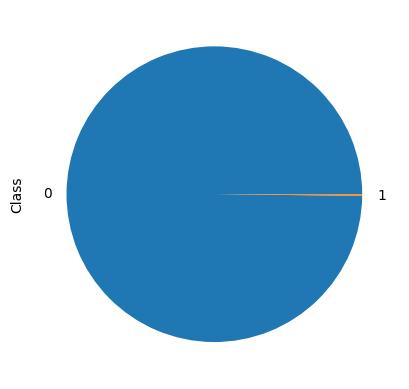

In [ ]:
# Check the class distribution in %
print((df.groupby('Class')['Class'].count()/df['Class'].count() * 100))
((df.groupby('Class')['Class'].count()/df['Class'].count() * 100)).plot.pie()

In [ ]:
# Check correlation
corr = df.corr()
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


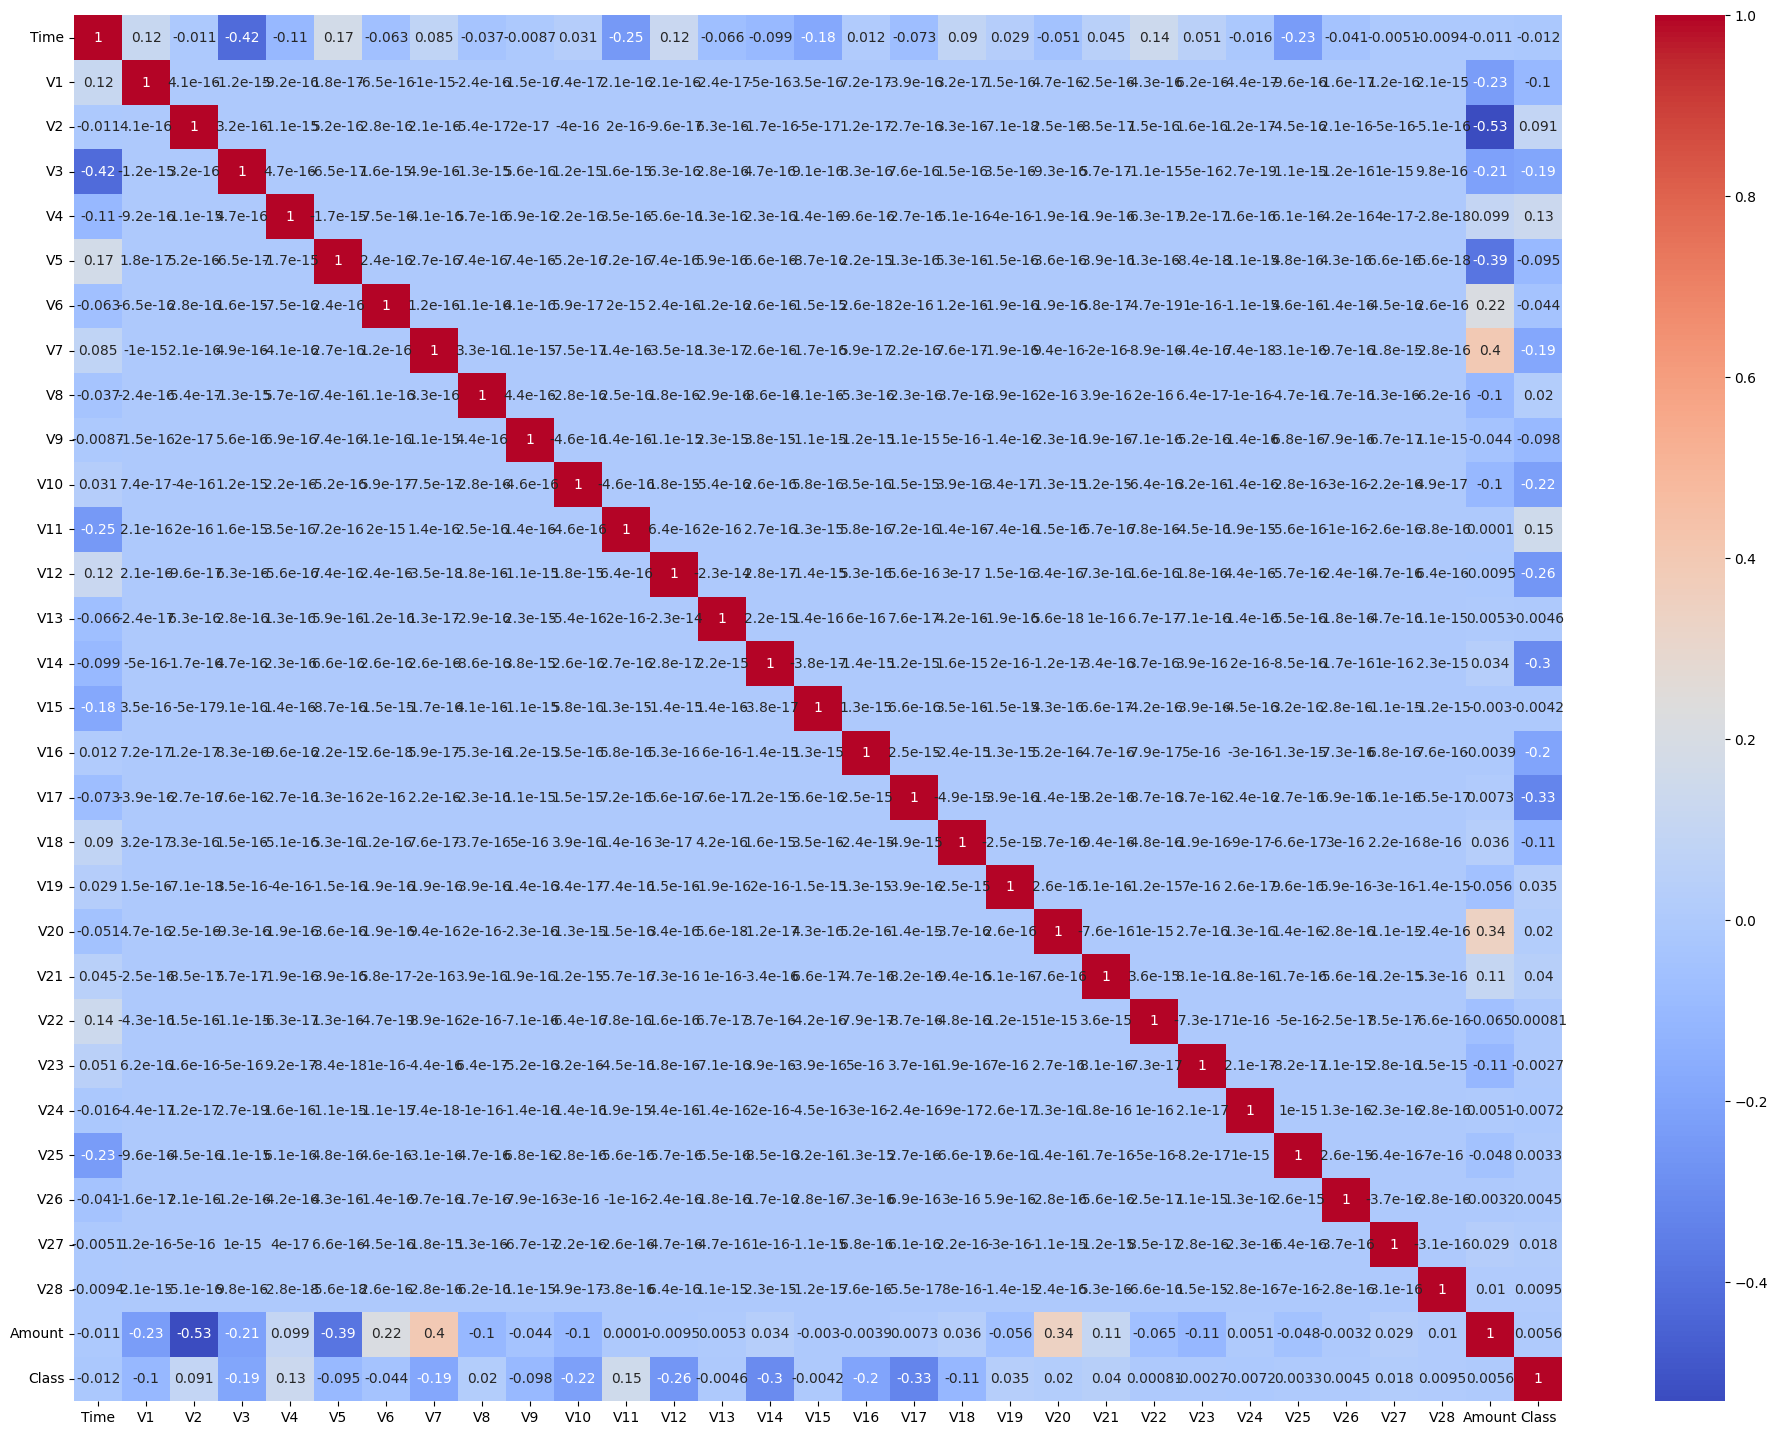

In [ ]:
# Check correlation using heatmap
plt.figure(figsize=(24,18))
sns.heatmap(corr,cmap='coolwarm',annot=True)
plt.show()

## **Feature Engingeering**

In [ ]:
# As time is given in a relative function, we use pandas.timedelta which represents a duration, the difference between two time
Delta_Time = pd.to_timedelta(df["Time"],unit='s')

# Create derived columns Mins and Hours
df['Time_Day'] = (Delta_Time.dt.components.days).astype(int)
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)
df['Time_Min'] = (Delta_Time.dt.components.minutes).astype(int)

In [ ]:
# Drop unwanted columns
df.drop(['Time','Time_Day','Time_Min'], axis = 1, inplace =True) # day/mins might not be very useful

##**Split data into Train and Test dataset**

In [ ]:
y = df['Class'] # variable of interest
X = df.drop(['Class'], axis = 1) # features

In [ ]:
# Split dataset using train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=100, test_size=0.2) #preserve the X_test and y_test to evaluate the model later

In [ ]:
# Check the speard of the data after splitting
print('Y:',np.sum(y))
print('Y train:',np.sum(y_train))
print('Y test:',np.sum(y_test))

Y: 492
Y train: 396
Y test: 96


Plotting the distribution of a feature

In [ ]:
# Accumulating all the feature names under one variable
cols = list(X.columns.values)

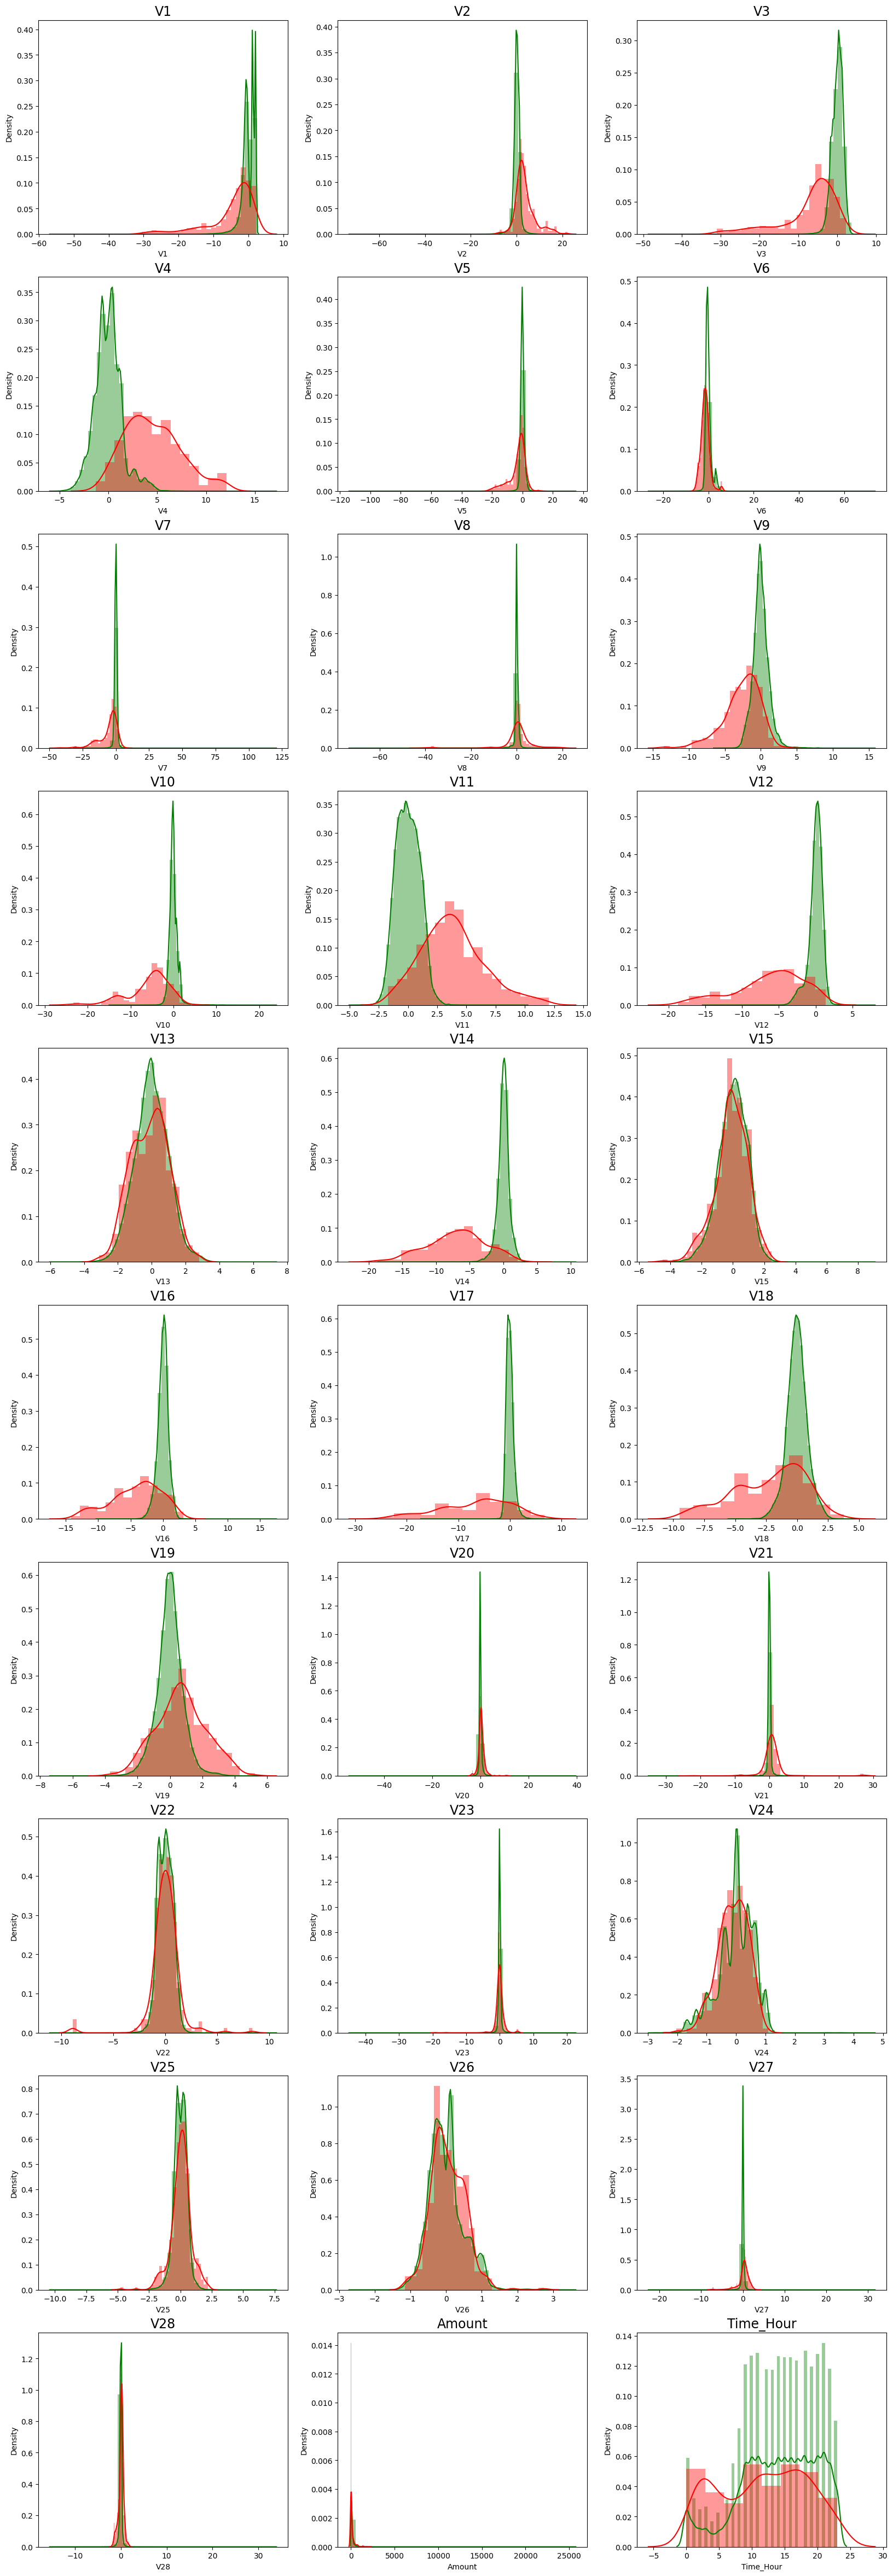

In [ ]:
# plot the histogram for features from the dataset to observe the skewness
normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20,60))
for i, f in enumerate(cols):
  plt.subplot(10,3,i+1)
  sns.distplot(X[f][normal_records], color='green')
  sns.distplot(X[f][fraud_records], color='red')
  plt.title(f, fontsize=17)
plt.show()

##**Create common functions for Models**

In [ ]:
# Create a dataframe to store results
df_results = pd.DataFrame(columns=['Methodology','Model','Accuracy','roc_value','threshold'])

In [ ]:
# Create a common function to plot confusion matrix
def plot_confusion_matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
  categoryNames = ['Non-Fraudalent','Fraudalent']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ticks = np.arange(len(categoryNames))
  plt.xticks(ticks, categoryNames, rotation=45)
  plt.yticks(ticks, categoryNames)
  s = [['TN','FP'],['FN','TP']]

  for i in range(2):
    for j in range(2):
      plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 12)
  plt.show()

In [ ]:
# Create a common function to fit and predict on a Logistic Regression model for both L1 and L2
def buildAndRunLogisticModels(df_results, Methodology, X_train, y_train, X_test, y_test):

  # Logistic Regression
  from sklearn import linear_model
  from sklearn.model_selection import KFold

  num_C = list(np.power(10.0, np.arange(-10,10)))
  cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

  searchCV_l2 = linear_model.LogisticRegressionCV(
      Cs= num_C,
      penalty='l2',
      scoring='roc_auc',
      cv=cv_num,
      random_state=42,
      max_iter=10000,
      fit_intercept=True,
      solver='newton-cg',
      tol=10
  )

  searchCV_l1 = linear_model.LogisticRegressionCV(
      Cs=num_C,
      penalty='l1',
      scoring='roc_auc',
      cv=cv_num,
      random_state=42,
      max_iter=10000,
      fit_intercept=True,
      solver='liblinear',
      tol=10
  )

  searchCV_l1.fit(X_train,y_train)
  searchCV_l2.fit(X_train,y_train)
  print('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())
  print('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())

  print("Parameters for l1 regularisation")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_)
  print(searchCV_l1.scores_)

  print("Parameters for l2 regularisation")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_)
  print(searchCV_l2.scores_)

  # Find predicted values
  y_pred_l1 = searchCV_l1.predict(X_test)
  y_pred_l2 = searchCV_l2.predict(X_test)

  # Find predicted probabilities
  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1]
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1]

  # Accuracy of L2/L1 models
  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print('Accuracy of Logistic model with l2 regularisation : {0}'.format(Accuracy_l2))
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred_l2)
  print('Classification Report')
  print(classification_report(y_test,y_pred_l2))

  print('Accuracy of Logistic model with l1 regularisation : {0}'.format(Accuracy_l1))
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred_l1)
  print('Classification Report')
  print(classification_report(y_test,y_pred_l1))

  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}".format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l2 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr,tpr)
  print("ROC for the test dataset", '{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology,'Model':'Logistic Regression with L2 Regularisation','Accuracy':Accuracy_l2,'roc_value':l2_roc_value,'threshold':threshold}, index=[0]),ignore_index=True)
  print('-'*60)

  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}".format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr,tpr)
  print("ROC for the test dataset", '{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology,'Model':'Logistic Regression with L1 Regularisation','Accuracy':Accuracy_l1,'roc_value':l1_roc_value,'threshold':threshold}, index=[0]),ignore_index=True)

  return df_results

In [ ]:
# Create a common function to fit and predict on a KNN model
def buildAndRunKNNModels(df_results,Methodology,X_train,y_train,X_test,y_test):

  #create KNN model and fit model with train set
  knn = KNeighborsClassifier(n_neighbors=5, n_jobs=16)
  knn.fit(X_train,y_train)
  score=knn.score(X_test,y_test)
  print('model score')
  print(score)

  #accuracy
  y_pred=knn.predict(X_test)
  KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred)
  print('Classification Report')
  print(classification_report(y_test,y_pred))

  knn_probs= knn.predict_proba(X_test)[:,1]

  #calcualte roc auc
  knn_roc_value = roc_auc_score(y_test, knn_probs)
  print(f'KNN roc_value: {knn_roc_value}')
  fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print(f'KNN threshold {threshold}')

  roc_auc = metrics.auc(fpr,tpr)
  print("ROC for the test data",'{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology,'Model':'KNN','Accuracy':score,'roc_value':knn_roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

In [ ]:
# Create a common function to fit and predict on a DecisionTreeModel for both gini and entropy criteria
def buildAndRunTreeModels(df_results,Methodology,X_train,y_train,X_test,y_test):
  #Evaluate Decision Tree model with 'gini' and 'entropy'
  criteria = ['gini','entropy']
  scores={}

  for c in criteria:
    dt = DecisionTreeClassifier(criterion=c, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    test_score = dt.score(X_test,y_test)
    tree_preds = dt.predict_proba(X_test)[:,1]
    tree_roc_value = roc_auc_score(y_test,tree_preds)
    scores= test_score
    print(c+ f" score: {test_score}")
    print('Confusion Matrix')
    plot_confusion_matrix(y_test, y_pred)
    print('Classification Report')
    print(classification_report(y_test,y_pred))
    print(c + f" tree_roc_value: {tree_roc_value}")
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print(f"Tree threshold: {threshold}")
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset", '{:.1%}'.format(roc_auc))

    df_results = df_results.append(pd.DataFrame({'Methodology':Methodology, 'Model':f'DecisionTree Model with {c} criteria', 'Accuracy':test_score,'roc_value':tree_roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

In [ ]:
# Create a common function to fit and predict on a Random Forest Model
def buildAndRunRandomForestModels(df_results,Methodology,X_train,y_train,X_test,y_test):
  # Evaluate Random Forest Model

  #create the model with 100 trees
  RF_model = RandomForestClassifier(
      n_estimators=100,
      bootstrap = True,
      max_features = 'sqrt', random_state=42)

  #fIt on training data
  RF_model.fit(X_train,y_train)
  RF_test_score= RF_model.score(X_test,y_test)
  RF_model.predict(X_test)

  print(f'Model Accuracy: {RF_test_score}')

  # Actual class predictions
  rf_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  plot_confusion_matrix(y_test, rf_predictions)
  print('Classification Report')
  print(classification_report(y_test,rf_predictions))

  #Probabilities for each class
  rf_probs = RF_model.predict_proba(X_test)[:,1]

  #Calculate roc auc
  roc_value = roc_auc_score(y_test, rf_probs)

  print(f"Random Forest roc value: {roc_value}")
  fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print(f"Random Forest threshold: {threshold}")
  roc_auc = metrics.auc(fpr,tpr)
  print("ROC for the test dataset:",'{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology, 'Model':'Random Forest', 'Accuracy':RF_test_score,'roc_value':roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

In [ ]:
# Create a common function to fit and predict on a XGBoost model
def buildAndRunXGBoostModels(df_results,Methodology,X_train,y_train,X_test,y_test):
  #Evaluate XGBoost model
  XGBmodel= XGBClassifier(random_state=42)
  XGBmodel.fit(X_train,y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print(f'Model Accuracy: {XGB_test_score}')

  print('Confusion Matrix')
  plot_confusion_matrix(y_test,y_pred)
  print("Classification Report")
  print(classification_report(y_test,y_pred))

  #Probabilities for each class
  XGB_probs = XGBmodel.predict_proba(X_test)[:,1]

  #Calcualte roc auc
  XGB_roc_value = roc_auc_score(y_test, XGB_probs)

  print(f'XGBoost roc value: {XGB_roc_value}')
  fpr,tpr,thresholds = metrics.roc_curve(y_test, XGB_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print(f'XGBoost threshold: {threshold}')
  roc_auc = metrics.auc(fpr,tpr)
  print('ROC for the test dataset', '{:.1%}'.format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology, 'Model':'XGBoost', 'Accuracy':XGB_test_score,'roc_value':XGB_roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

In [ ]:
# Create a common function to fit and predict on a SVM model
def buildAndRunSVMModels(df_results,Methodology,X_train,y_train,X_test,y_test):
  #Evaluate SVM model with sigmoid kernel model
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import roc_auc_score

  clf = SVC(kernel="sigmoid", random_state=42)
  clf.fit(X_train,y_train)
  y_pred_SVM = clf.predict(X_test)
  SVM_score = accuracy_score(y_test, y_pred_SVM)
  print(f'Accuracy score: {SVM_score}')
  print('Confusion Matrix')
  plot_confusion_matrix(y_test, y_pred_SVM)
  print("Classification Report")
  print(classification_report(y_test, y_pred_SVM))

  #Run classifier
  classifier = SVC(kernel="sigmoid", probability = True)
  svm_probs = classifier.fit(X_train, y_train).predict_proba(X_test)[:,1]

  #Calcualte roc auc
  roc_value = roc_auc_score(y_test, svm_probs)

  print(f"SVM roc value: {roc_value}")
  fpr,tpr,thresholds = metrics.roc_curve(y_test, svm_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print(f"SVM threshold: {threshold}")
  roc_auc = metrics.auc(fpr,tpr)
  print('ROC for the test dataset', "{:.1%}".format(roc_auc))

  df_results = df_results.append(pd.DataFrame({'Methodology':Methodology, 'Model':'SVM', 'Accuracy':SVM_score,'roc_value':roc_value,'threshold':threshold},index=[0]),ignore_index=True)

  return df_results

##**Model Building (Imbalanced datset)**

###**Perform cross validation with RepeatedKFold**

In [ ]:
#Perform RepeatedKFold and check results
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in rkf.split(X,y):
  print("TRAIN:", train_index, "TEST", test_index)
  X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [     0      2      3 ... 284803 284805 284806] TEST [     1      8     24 ... 284787 284788 284804]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST [    11     17     19 ... 284798 284802 284803]
TRAIN: [     0      1      2 ... 284803 284804 284805] TEST [     5     10     12 ... 284799 284800 284806]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST [     3      7      9 ... 284777 284790 284795]
TRAIN: [     1      3      5 ... 284803 284804 284806] TEST [     0      2      4 ... 284792 284801 284805]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST [     9     13     22 ... 284788 284794 284803]
TRAIN: [     1      2      3 ... 284801 284803 284806] TEST [     0      5     11 ... 284802 284804 284805]
TRAIN: [     0      1      2 ... 284803 284804 284805] TEST [     3      7      8 ... 284791 284801 284806]
TRAIN: [     0      1      3 ... 284804 284805 284806] TEST [     2      4      6 ... 284769 284787 284796]
TRAIN: [     0      2      3

Logistic Regression with L1 and L2 regularisation
Max auc_roc for l1: 0.9737754872000582
Max auc_roc for l2: 0.9831072887653594
Parameters for l1 regularisation
[[-0.05450023 -0.1222497  -0.17989517  0.06297462 -0.26100753  0.0920597
   0.11791087 -0.03257627 -0.14362867 -0.14552004 -0.03453469  0.00991979
  -0.13980246 -0.22416146  0.01347083 -0.11487287 -0.22034874  0.03704322
   0.00818584  0.23494551  0.08959342 -0.0268195   0.00870863 -0.00939169
  -0.02577108  0.00262997 -0.06742851 -0.00506468 -0.00638242 -0.11668264]]
[-2.1015215]
{1: array([[0.5       , 0.5       , 0.5       , 0.5       , 0.54019022,
        0.51484003, 0.56349778, 0.92002426, 0.93323481, 0.93616685,
        0.92706072, 0.93064095, 0.94479728, 0.9358298 , 0.94125538,
        0.94708903, 0.92969403, 0.93993421, 0.94460564, 0.98979251],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.57655803,
        0.52019209, 0.52359907, 0.89655427, 0.92525587, 0.95143569,
        0.9058629 , 0.90939995, 0.9345645 

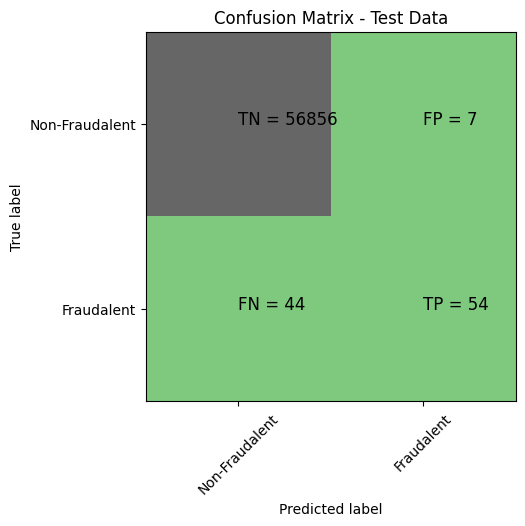

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.89      0.55      0.68        98

    accuracy                           1.00     56961
   macro avg       0.94      0.78      0.84     56961
weighted avg       1.00      1.00      1.00     56961

Accuracy of Logistic model with l1 regularisation : 0.9991397622934991
Confusion Matrix


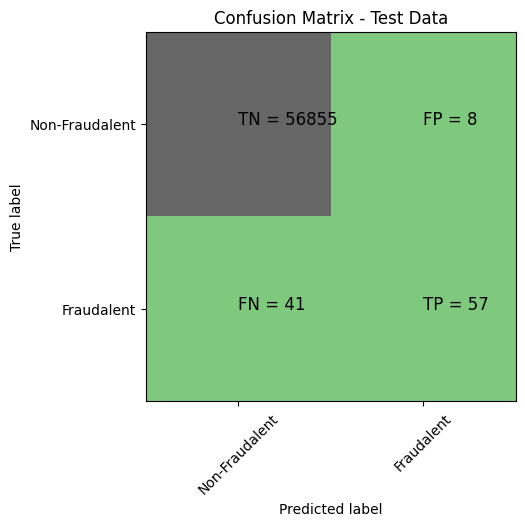

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.58      0.70        98

    accuracy                           1.00     56961
   macro avg       0.94      0.79      0.85     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9876145206864906
l2 threshold: 0.0019342556972745712
ROC for the test dataset 98.8%
------------------------------------------------------------
l1 roc_value: 0.8804550643921463
l1 threshold: 0.09541321822211335
ROC for the test dataset 88.0%
Time taken by model: ---419.966295003891 seconds
------------------------------------------------------------
KNN Model
model score
0.999350432752234
Confusion Matrix


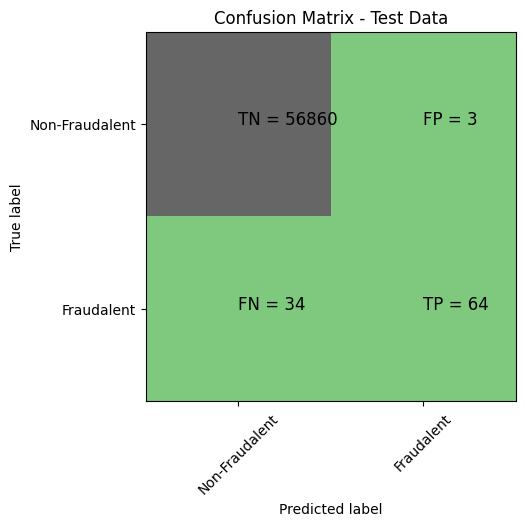

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.65      0.78        98

    accuracy                           1.00     56961
   macro avg       0.98      0.83      0.89     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.8825096804456971
KNN threshold 0.2
ROC for the test data 88.3%
Time taken by model: ---266.10006523132324 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.9991924299081828
Confusion Matrix


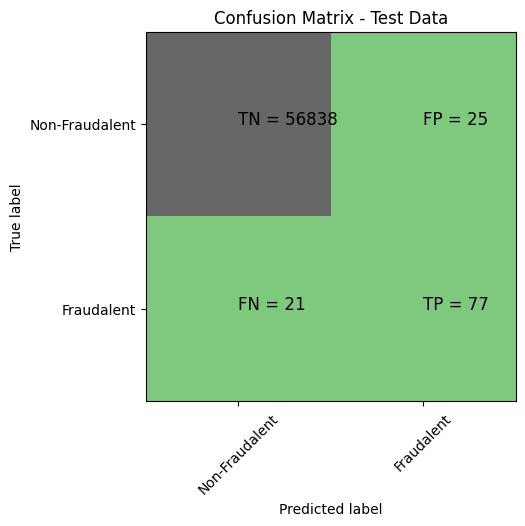

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.75      0.79      0.77        98

    accuracy                           1.00     56961
   macro avg       0.88      0.89      0.88     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8926373162563654
Tree threshold: 1
ROC for the test dataset 89.3%
entropy score: 0.9992450975228665
Confusion Matrix


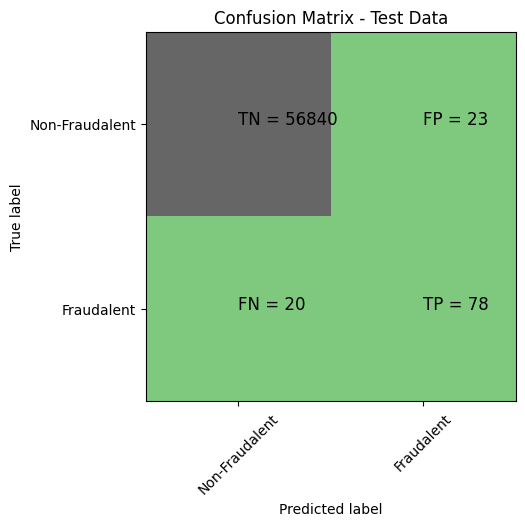

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.77      0.80      0.78        98

    accuracy                           1.00     56961
   macro avg       0.89      0.90      0.89     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8977569432007543
Tree threshold: 1
ROC for the test dataset 89.8%
Time taken by model: ---40.59489059448242 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9996313266972139
Confusion Matrix


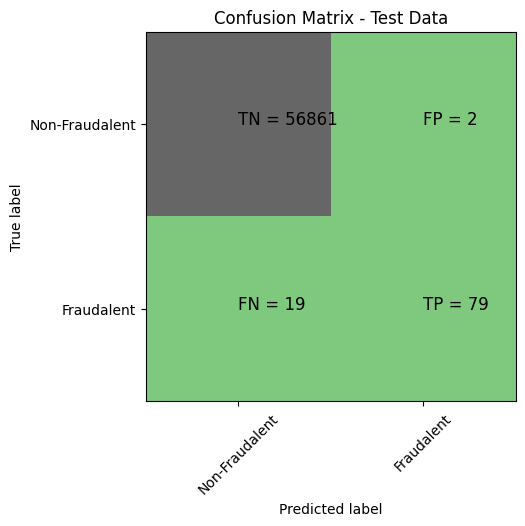

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.81      0.88        98

    accuracy                           1.00     56961
   macro avg       0.99      0.90      0.94     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc value: 0.9424673409451361
Random Forest threshold: 0.03
ROC for the test dataset: 94.2%
Time taken by model: ---302.8366394042969 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9996137708256526
Confusion Matrix


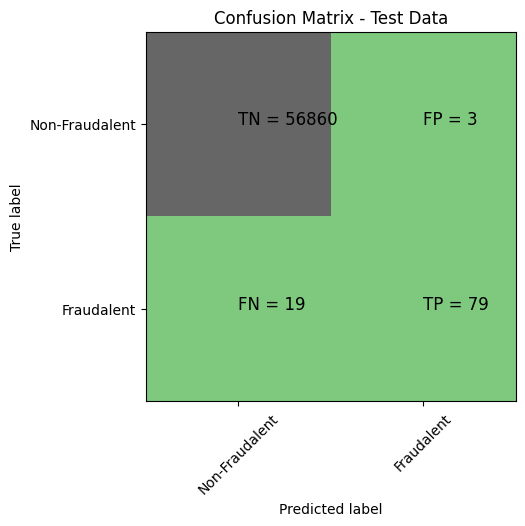

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.81      0.88        98

    accuracy                           1.00     56961
   macro avg       0.98      0.90      0.94     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost roc value: 0.9763469269317913
XGBoost threshold: 0.0001784323394531384
ROC for the test dataset 97.6%
Time taken by model: ---4.992119550704956 seconds
------------------------------------------------------------


In [ ]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_results = buildAndRunLogisticModels(df_results,"RepeatedKFold CV", X_train_cv, y_train_cv,X_test_cv,y_test_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_results = buildAndRunKNNModels(df_results,"RepeatedKFold CV", X_train_cv, y_train_cv,X_test_cv,y_test_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_results = buildAndRunTreeModels(df_results,"RepeatedKFold CV", X_train_cv, y_train_cv,X_test_cv,y_test_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_results = buildAndRunRandomForestModels(df_results,"RepeatedKFold CV", X_train_cv, y_train_cv,X_test_cv,y_test_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_results = buildAndRunXGBoostModels(df_results,"RepeatedKFold CV", X_train_cv, y_train_cv,X_test_cv,y_test_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run SVM Model
#print('SVM Model')
#start_time= time.time()
#df_results = buildAndRunSVMModels(df_results,"RepeatedKFold CV", X_train_cv, y_train_cv,X_test_cv,y_test_cv)
#print("Time taken by model: ---%s seconds" % (time.time()-start_time))
#print('-'*60)

###**Perform cross validation with StratifiedKFold**

In [ ]:
# Perform stratifiedKFold and check the results
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the features and y is the target
for train_index, test_index in skf.split(X,y):
  print('TRAIN:',train_index, "TEST:", test_index)
  X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 30473  30496  31002 ... 284804 284805 284806] TEST: [    0     1     2 ... 57017 57018 57019]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 30473  30496  31002 ... 113964 113965 113966]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 81609  82400  83053 ... 170946 170947 170948]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150654 150660 150661 ... 227866 227867 227868]
TRAIN: [     0      1      2 ... 227866 227867 227868] TEST: [212516 212644 213092 ... 284804 284805 284806]


Logistic Regression with L1 and L2 regularisation
Max auc_roc for l1: 0.9652106893977332
Max auc_roc for l2: 0.9824998302436573
Parameters for l1 regularisation
[[-0.03660539 -0.1358827  -0.20474594  0.04333662 -0.24034598  0.08416903
   0.12654905 -0.04815306 -0.14258132 -0.1384162  -0.11668372  0.05505155
  -0.15637116 -0.24216184 -0.03137093 -0.09904364 -0.23133976  0.05582481
   0.02122044  0.20503748  0.09013502  0.00148754 -0.03796378 -0.00392139
  -0.14797782 -0.00701001 -0.06594801 -0.00660368 -0.00656465 -0.12981985]]
[-2.0409044]
{1: array([[0.5       , 0.5       , 0.5       , 0.5       , 0.48341269,
        0.44979055, 0.48500892, 0.78098262, 0.9497821 , 0.94525947,
        0.91827811, 0.91446679, 0.94989144, 0.94933682, 0.94178407,
        0.94900653, 0.92481293, 0.94421561, 0.9164553 , 0.97793244],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.54612019,
        0.57709187, 0.60597219, 0.84651057, 0.93343227, 0.93465714,
        0.92629828, 0.92557122, 0.9448154

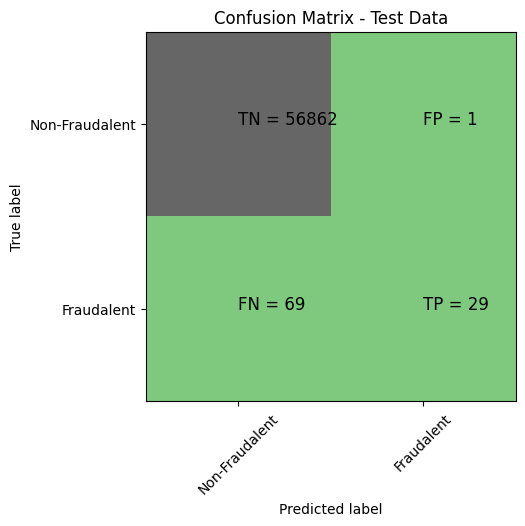

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.97      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.98      0.65      0.73     56961
weighted avg       1.00      1.00      1.00     56961

Accuracy of Logistic model with l1 regularisation : 0.9987535331191517
Confusion Matrix


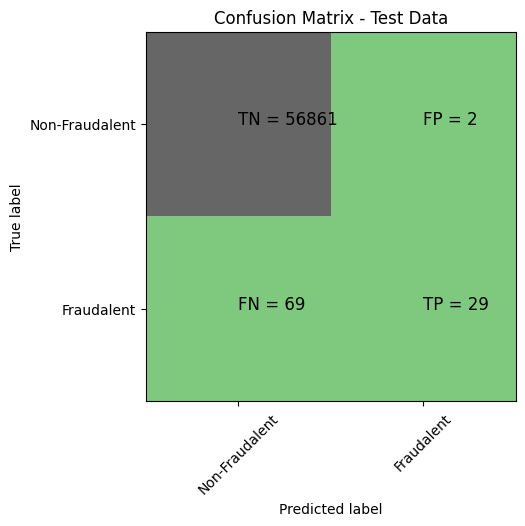

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.97      0.65      0.72     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9833866719401124
l2 threshold: 0.0015540600590433185
ROC for the test dataset 98.3%
------------------------------------------------------------
l1 roc_value: 0.8890758561483437
l1 threshold: 0.021087492766199863
ROC for the test dataset 88.9%
Time taken by model: ---395.08147144317627 seconds
------------------------------------------------------------
KNN Model
model score
0.9991924299081828
Confusion Matrix


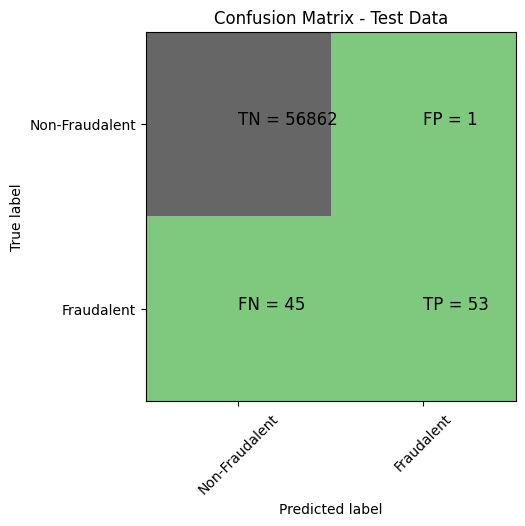

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.54      0.70        98

    accuracy                           1.00     56961
   macro avg       0.99      0.77      0.85     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.8057457828285457
KNN threshold 0.2
ROC for the test data 80.6%
Time taken by model: ---254.12153697013855 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.998841312476958
Confusion Matrix


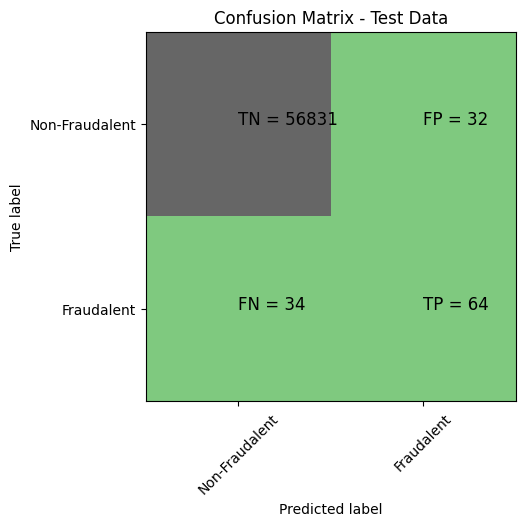

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.65      0.66        98

    accuracy                           1.00     56961
   macro avg       0.83      0.83      0.83     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8262492341959029
Tree threshold: 1
ROC for the test dataset 82.6%
entropy score: 0.9990168711925703
Confusion Matrix


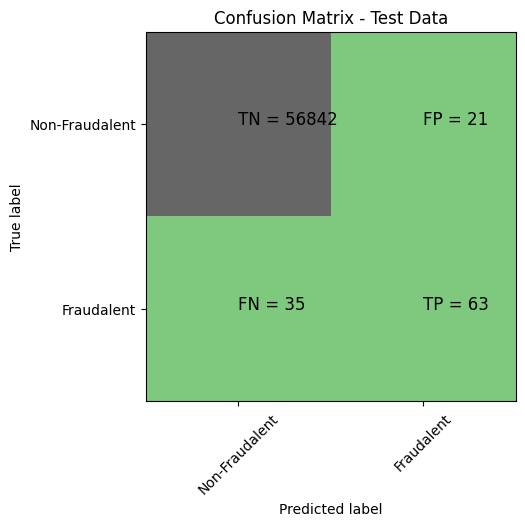

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.75      0.64      0.69        98

    accuracy                           1.00     56961
   macro avg       0.87      0.82      0.85     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8212439170839185
Tree threshold: 1
ROC for the test dataset 82.1%
Time taken by model: ---39.65397644042969 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


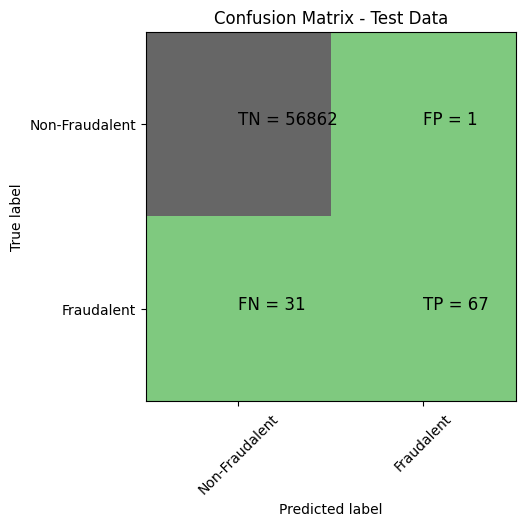

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc value: 0.9464721329855826
Random Forest threshold: 0.01
ROC for the test dataset: 94.6%
Time taken by model: ---286.22021532058716 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


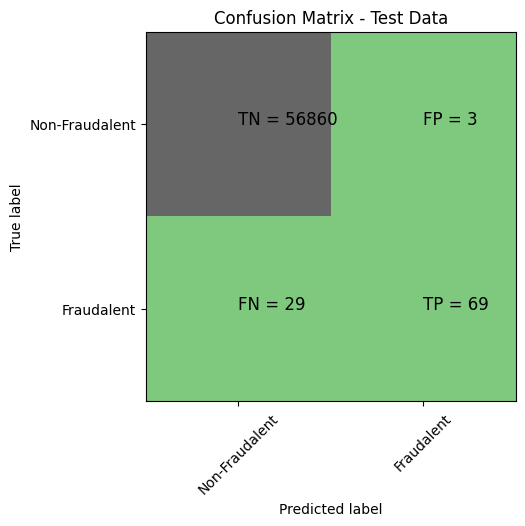

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.70      0.81        98

    accuracy                           1.00     56961
   macro avg       0.98      0.85      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost roc value: 0.9722049451474309
XGBoost threshold: 3.768169699469581e-05
ROC for the test dataset 97.2%
Time taken by model: ---4.74185585975647 seconds
------------------------------------------------------------


In [ ]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_results = buildAndRunLogisticModels(df_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_results = buildAndRunKNNModels(df_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_results = buildAndRunTreeModels(df_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_results = buildAndRunRandomForestModels(df_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_results = buildAndRunXGBoostModels(df_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run SVM Model
#print('SVM Model')
#start_time= time.time()
#df_results = buildAndRunSVMModels(df_results,"StratifiedKFold CV", X_train_SKF_cv, y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
#print("Time taken by model: ---%s seconds" % (time.time()-start_time))
#print('-'*60)

In [ ]:
df_results.sort_values('roc_value', ascending = False)

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold CV,Logistic Regression with L2 Regularisation,0.999105,0.987615,0.001934
7,StratifiedKFold CV,Logistic Regression with L2 Regularisation,0.998771,0.983387,0.001554
6,RepeatedKFold CV,XGBoost,0.999614,0.976347,0.000178
13,StratifiedKFold CV,XGBoost,0.999438,0.972205,0.000038
12,StratifiedKFold CV,Random Forest,0.999438,0.946472,0.010000
5,RepeatedKFold CV,Random Forest,0.999631,0.942467,0.030000
4,RepeatedKFold CV,DecisionTree Model with entropy criteria,0.999245,0.897757,1.000000
3,RepeatedKFold CV,DecisionTree Model with gini criteria,0.999192,0.892637,1.000000
8,StratifiedKFold CV,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087
2,RepeatedKFold CV,KNN,0.999350,0.882510,0.200000


**Conclusion**

The df_results dataframe shows that Logistic Regression with L2 Regularisation using the StratifiedKFold Cross Validation provided the best results (roc_value).

###**Proceeding with the model which shows the best result**

*   Apply the best hyperparameter on the model
*   Predict on the test dataset

In [ ]:
# Logistic regression
from sklearn import linear_model
from sklearn.model_selection import KFold

num_C = list(np.power(10.0, np.arange(-10,10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

clf = linear_model.LogisticRegressionCV(
    Cs=num_C,
    penalty='l2',
    scoring='roc_auc',
    cv=cv_num,
    random_state=42,
    max_iter=10000,
    fit_intercept=True,
    solver='newton-cg',
    tol=10
)

clf.fit(X_train_SKF_cv, y_train_SKF_cv)
print("Max auc_roc for l2:", clf.scores_[1].mean(axis=0).max())

print("Parameters for l2 regularisations")
print(clf.coef_)
print(clf.intercept_)
print(clf.scores_)

# Find predicted values
y_pred_l2 = clf.predict(X_test)

# Find predicted probabilities
y_pred_probs_l2 = clf.predict_proba(X_test)[:,1]

# Accuracy of L2 models
accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)

print(f"Accuracy of Logistic model with l2 regularisation: {accuracy_l2}")

from sklearn.metrics import roc_auc_score
l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
print(f"l2 roc_value: {l2_roc_value}")
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
threshold = thresholds[np.argmax(tpr-fpr)]
print(f"l2 threshold: {threshold}")

Max auc_roc for l2: 0.9824998302436573
Parameters for l2 regularisations
[[ 0.00683334  0.06145934 -0.06703104  0.21837008  0.05400372 -0.0319603
  -0.02280335 -0.1149601  -0.06954056 -0.16366435  0.12779    -0.19159896
  -0.03711445 -0.36059637  0.00364854 -0.08799108 -0.07288165 -0.0007583
   0.00394511 -0.0279599   0.03822224  0.02337054 -0.01173993 -0.00997821
  -0.00657592  0.00627513 -0.01025023 -0.00174467  0.00039791 -0.00096784]]
[-7.40641365]
{1: array([[0.69243733, 0.69420152, 0.71447107, 0.83768575, 0.95579612,
        0.97136042, 0.98915673, 0.99464431, 0.99129517, 0.99071237,
        0.99096601, 0.99096601, 0.99096601, 0.99096601, 0.99096601,
        0.99096601, 0.99096601, 0.99096601, 0.99096601, 0.99096601],
       [0.60700243, 0.60865586, 0.62914551, 0.76884136, 0.90900227,
        0.94879974, 0.9604112 , 0.98181412, 0.98547001, 0.98328227,
        0.97955152, 0.97955152, 0.97955152, 0.97955152, 0.97955152,
        0.97955152, 0.97955152, 0.97955152, 0.97955152, 0.9795

In [ ]:
# Check for the coef values
clf.coef_

array([[ 0.00683334,  0.06145934, -0.06703104,  0.21837008,  0.05400372,
        -0.0319603 , -0.02280335, -0.1149601 , -0.06954056, -0.16366435,
         0.12779   , -0.19159896, -0.03711445, -0.36059637,  0.00364854,
        -0.08799108, -0.07288165, -0.0007583 ,  0.00394511, -0.0279599 ,
         0.03822224,  0.02337054, -0.01173993, -0.00997821, -0.00657592,
         0.00627513, -0.01025023, -0.00174467,  0.00039791, -0.00096784]])

In [ ]:
# Create dataframe for coef values
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefficients.columns = ['Feature','Coefficient Importance']
coefficients

,Feature,Coefficient Importance
0,V1,0.006833
1,V2,0.061459
2,V3,-0.067031
3,V4,0.218370
4,V5,0.054004
5,V6,-0.031960
6,V7,-0.022803
7,V8,-0.114960
8,V9,-0.069541
9,V10,-0.163664


**Print the important features of the best model to understand the dataset**


*   This will not give much explanation on the already transformed data
*   But it will help us understand if the dataset is not PCA transformed



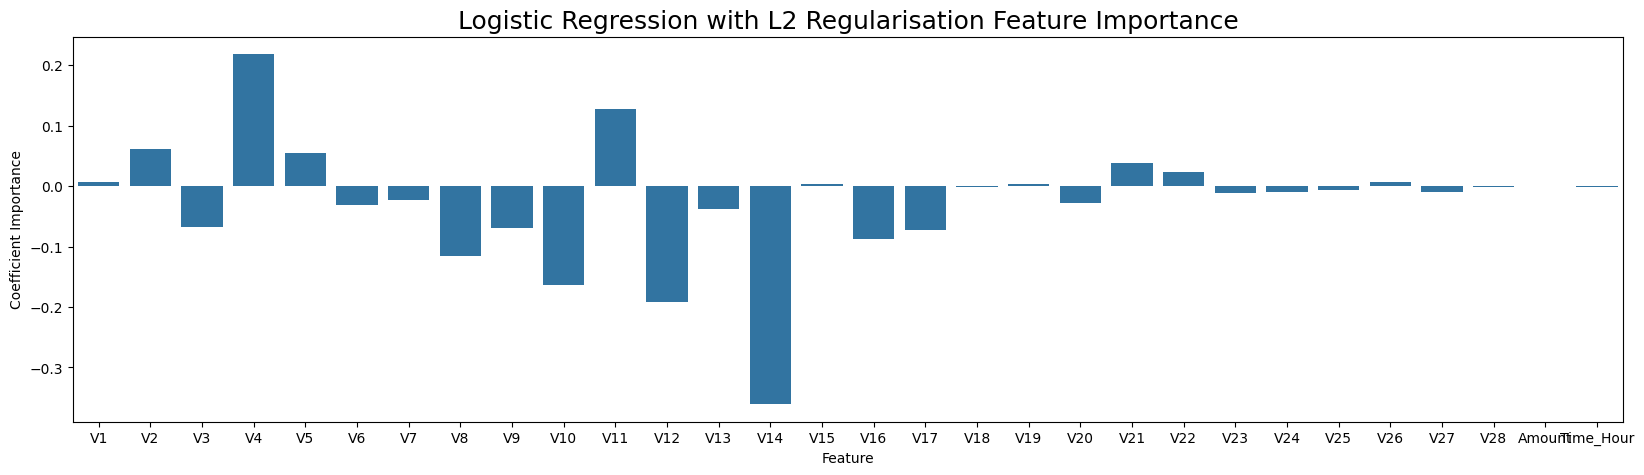

In [ ]:
# Plotting the coef values
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient Importance', data=coefficients)
plt.title('Logistic Regression with L2 Regularisation Feature Importance', fontsize=18)
plt.show()

We observe that V4,V5,V11 has +ve impact whereas V10,V12,V14 seems to have -ve impact on the predictions.

##**Model building with Balancing Classes**

**Perform class balancing with:**
*   Random Oversampling
*   SMOTE
*   ADASYN (Adaptive Synthetic)





###**Oversampling with RandomOverSampler with StratifiedKFold Cross Validation**

In [ ]:
# Create the dataset with RandomOverSampler and StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
  X_train = X.loc[train_index]
  y_train = y.loc[train_index]
  X_test = X.loc[test_index]
  y_test = y.loc[test_index]
  ROS = RandomOverSampler(sampling_strategy=0.5)
  X_over, y_over = ROS.fit_resample(X_train, y_train)

X_over = pd.DataFrame(data=X_over, columns = cols)

Logistic Regression with L1 and L2 regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9866057948860514
Parameters for l1 regularisation
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

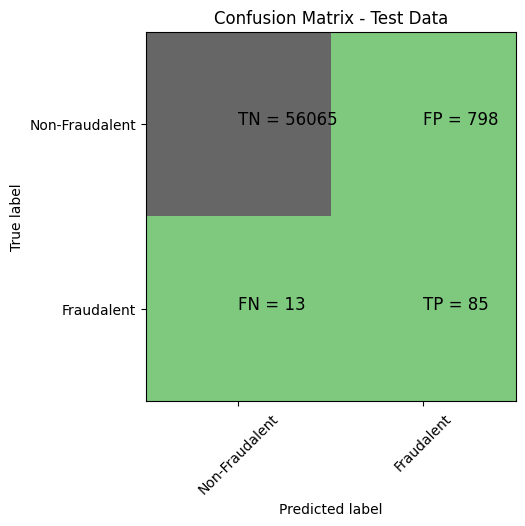

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.10      0.87      0.17        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.58     56961
weighted avg       1.00      0.99      0.99     56961

Accuracy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


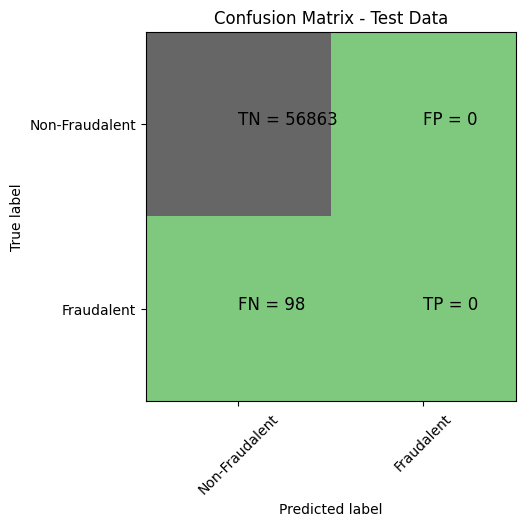

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9807227324392641
l2 threshold: 0.32974439228304075
ROC for the test dataset 98.1%
------------------------------------------------------------
l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%
Time taken by model: ---526.8544900417328 seconds
------------------------------------------------------------
KNN Model
model score
0.9980688541282632
Confusion Matrix


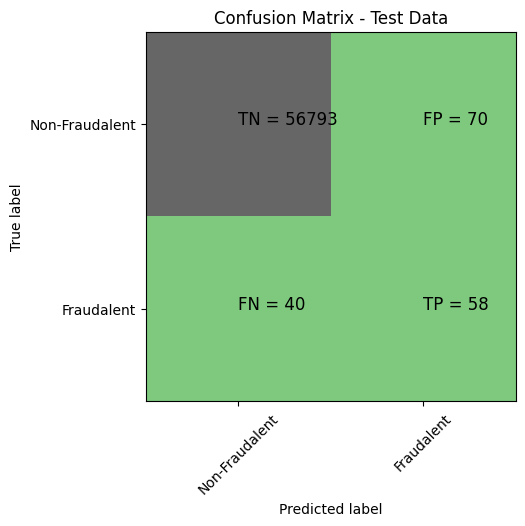

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.45      0.59      0.51        98

    accuracy                           1.00     56961
   macro avg       0.73      0.80      0.76     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc_value: 0.805604465728046
KNN threshold 0.2
ROC for the test data 80.6%
Time taken by model: ---373.17017364501953 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.9991748740366215
Confusion Matrix


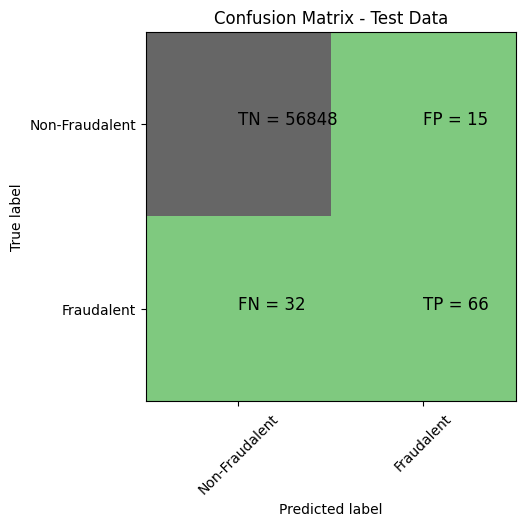

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.81      0.67      0.74        98

    accuracy                           1.00     56961
   macro avg       0.91      0.84      0.87     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8366027979170847
Tree threshold: 1
ROC for the test dataset 83.7%
entropy score: 0.9991748740366215
Confusion Matrix


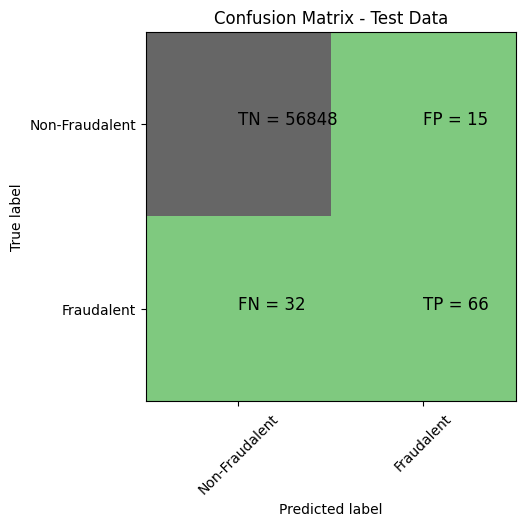

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.81      0.67      0.74        98

    accuracy                           1.00     56961
   macro avg       0.91      0.84      0.87     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8366027979170847
Tree threshold: 1
ROC for the test dataset 83.7%
Time taken by model: ---33.50506782531738 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995084355962852
Confusion Matrix


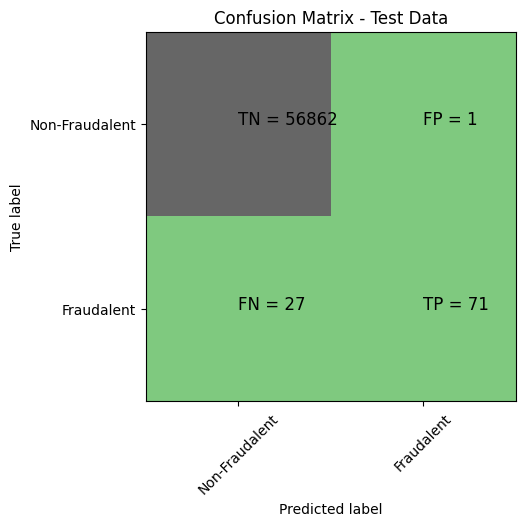

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.72      0.84        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc value: 0.9402987739597537
Random Forest threshold: 0.02
ROC for the test dataset: 94.0%
Time taken by model: ---215.84106254577637 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994557679816014
Confusion Matrix


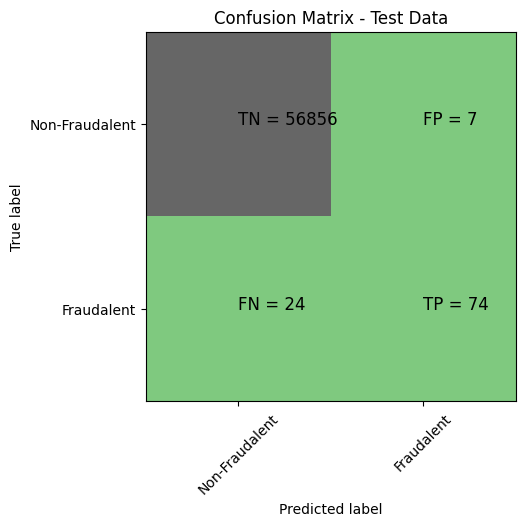

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.76      0.83        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost roc value: 0.9762258877136489
XGBoost threshold: 0.00017200758156832308
ROC for the test dataset 97.6%
Time taken by model: ---10.746806383132935 seconds
------------------------------------------------------------


In [ ]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_results = buildAndRunLogisticModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_results = buildAndRunKNNModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_results = buildAndRunTreeModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_results = buildAndRunRandomForestModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_results = buildAndRunXGBoostModels(df_results,"Random Oversampling with StratifiedKFold CV", X_over, y_over ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

**Results from Random Oversampling with StratifiedKFold technique:**

Looking at the Accuracy and ROC value, XGBoost provided the best results for Random Oversampling and StratifiedKFold technique

###**Oversampling with SMOTE Oversampling**
*   We will use SMOTE Oversampling method to handle the class imbalance

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
  X_train = X.loc[train_index]
  y_train = y.loc[train_index]
  X_test = X.loc[test_index]
  y_test = y.loc[test_index]
  SMOTE = over_sampling.SMOTE(random_state=0)
  X_train_Smote, y_train_Smote = SMOTE.fit_resample(X_train, y_train)

X_train_Smote = pd.DataFrame(data=X_train_Smote, columns = cols)

Logistic Regression with L1 and L2 regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9930151908600335
Parameters for l1 regularisation
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

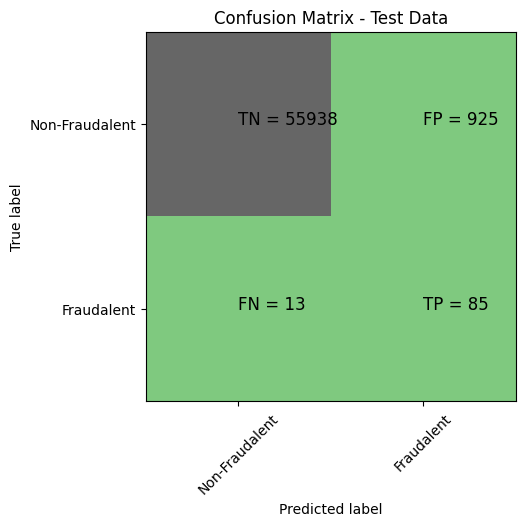

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.08      0.87      0.15        98

    accuracy                           0.98     56961
   macro avg       0.54      0.93      0.57     56961
weighted avg       1.00      0.98      0.99     56961

Accuracy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


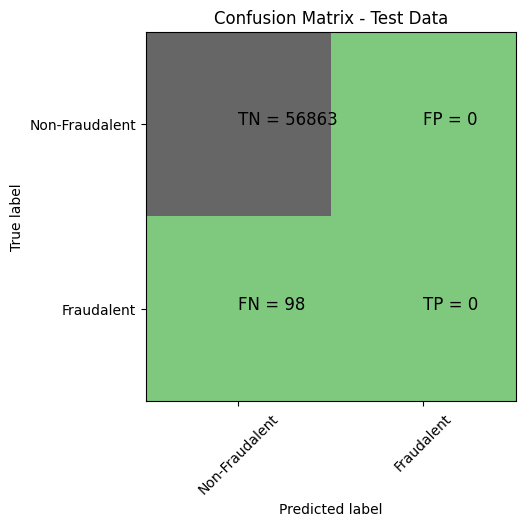

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9745828408918391
l2 threshold: 0.3939516300872773
ROC for the test dataset 97.5%
------------------------------------------------------------
l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%
Time taken by model: ---670.2364683151245 seconds
------------------------------------------------------------
KNN Model
model score
0.9946805709169432
Confusion Matrix


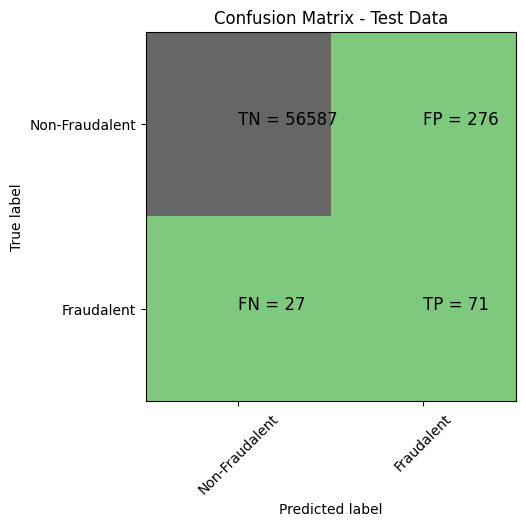

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.20      0.72      0.32        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.66     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc_value: 0.8602674455287628
KNN threshold 0.6
ROC for the test data 86.0%
Time taken by model: ---490.63934898376465 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.9977528484401608
Confusion Matrix


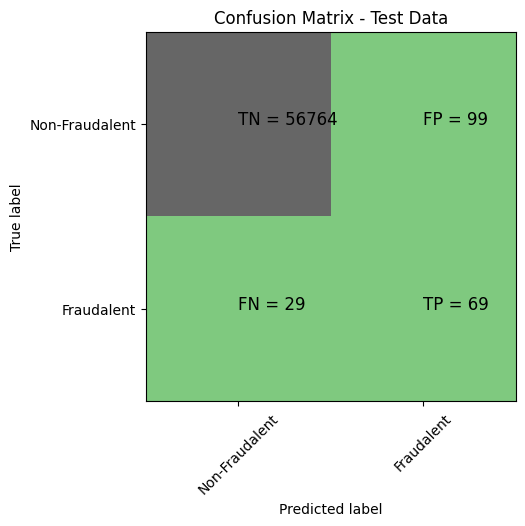

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.41      0.70      0.52        98

    accuracy                           1.00     56961
   macro avg       0.71      0.85      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8511703029874526
Tree threshold: 1
ROC for the test dataset 85.1%
entropy score: 0.9969803900914661
Confusion Matrix


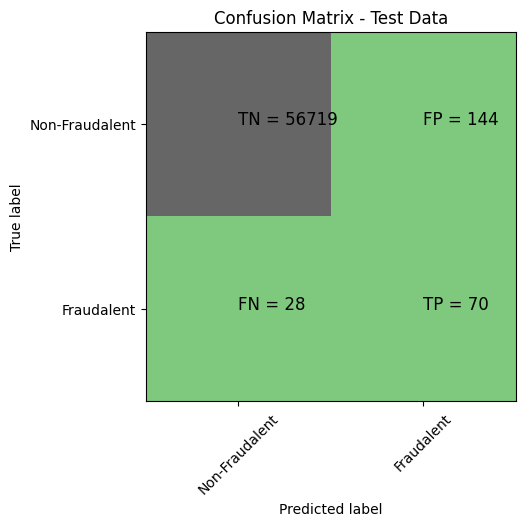

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.33      0.71      0.45        98

    accuracy                           1.00     56961
   macro avg       0.66      0.86      0.72     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8558766559223799
Tree threshold: 1
ROC for the test dataset 85.6%
Time taken by model: ---94.93536424636841 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.999490879724724
Confusion Matrix


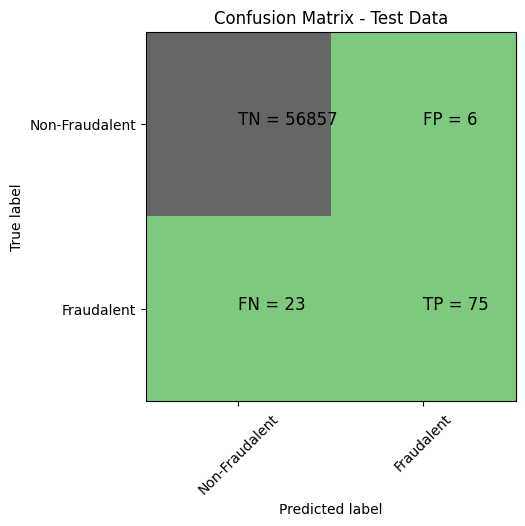

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc value: 0.9614705879186172
Random Forest threshold: 0.05
ROC for the test dataset: 96.1%
Time taken by model: ---507.08844089508057 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.9994031003669177
Confusion Matrix


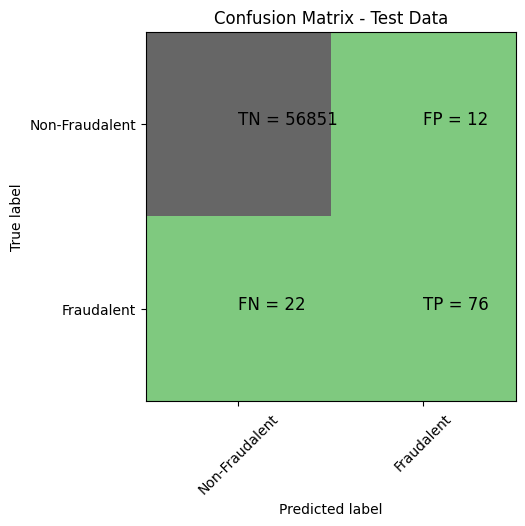

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.78      0.82        98

    accuracy                           1.00     56961
   macro avg       0.93      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost roc value: 0.9704734293344512
XGBoost threshold: 0.000144163059303537
ROC for the test dataset 97.0%
Time taken by model: ---13.461556673049927 seconds
------------------------------------------------------------


In [ ]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_results = buildAndRunLogisticModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_results = buildAndRunKNNModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_results = buildAndRunTreeModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_results = buildAndRunRandomForestModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_results = buildAndRunXGBoostModels(df_results,"SMOTE Oversampling with StratifiedKFold", X_train_Smote, y_train_Smote ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

**Results from SMOTE Oversampling with StratifiedKFold:**

XGBoost provided best results.

###**Oversampling with ADASYN Oversampling**
*   Use ADASYN Oversampling method to handle the class imbalance

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
  X_train = X.loc[train_index]
  y_train = y.loc[train_index]
  X_test = X.loc[test_index]
  y_test = y.loc[test_index]
  ADASYN = over_sampling.ADASYN(random_state=0)
  X_train_ADASYN, y_train_ADASYN = ADASYN.fit_resample(X_train, y_train)

X_train_ADASYN = pd.DataFrame(data=X_train_ADASYN, columns = cols)

Logistic Regression with L1 and L2 regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9835137791366966
Parameters for l1 regularisation
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{1: array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

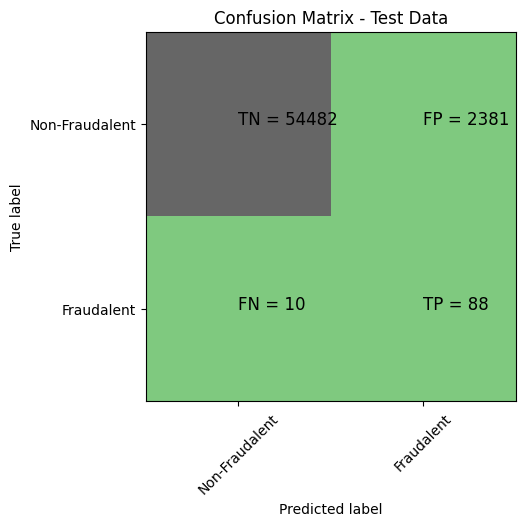

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.90      0.07        98

    accuracy                           0.96     56961
   macro avg       0.52      0.93      0.52     56961
weighted avg       1.00      0.96      0.98     56961

Accuracy of Logistic model with l1 regularisation : 0.9982795245869981
Confusion Matrix


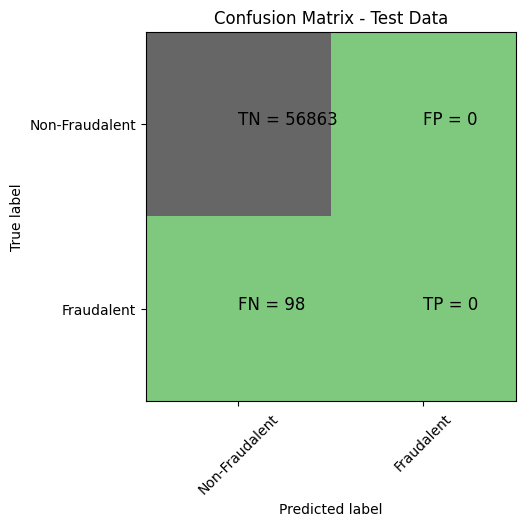

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.9740284292321646
l2 threshold: 0.6115468403459997
ROC for the test dataset 97.4%
------------------------------------------------------------
l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%
Time taken by model: ---739.9825978279114 seconds
------------------------------------------------------------
KNN Model
model score
0.9945050122013307
Confusion Matrix


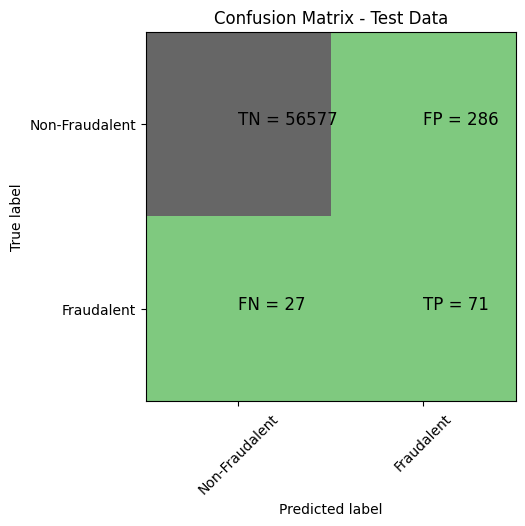

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.20      0.72      0.31        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.65     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc_value: 0.8601937811862167
KNN threshold 0.6
ROC for the test data 86.0%
Time taken by model: ---494.3141043186188 seconds
------------------------------------------------------------
Decision Tree Models with gini and entropy criteria
gini score: 0.9979459630273345
Confusion Matrix


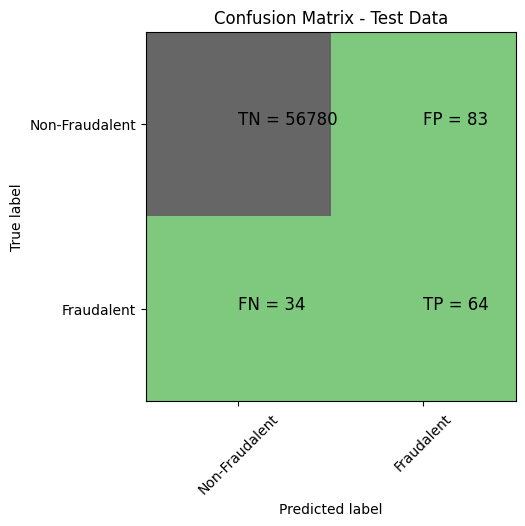

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.44      0.65      0.52        98

    accuracy                           1.00     56961
   macro avg       0.72      0.83      0.76     56961
weighted avg       1.00      1.00      1.00     56961

gini tree_roc_value: 0.8258007879303172
Tree threshold: 1
ROC for the test dataset 82.6%
entropy score: 0.9954179175225154
Confusion Matrix


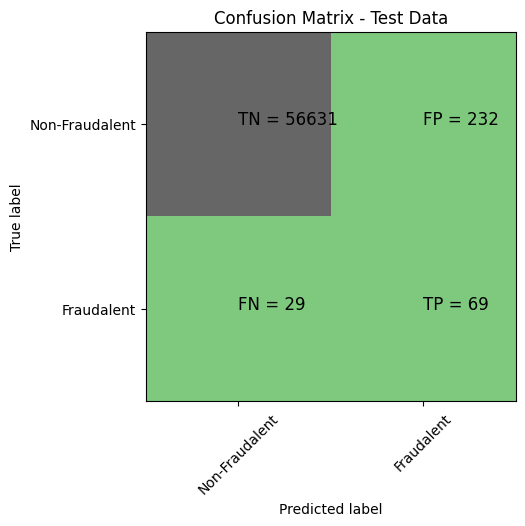

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.23      0.70      0.35        98

    accuracy                           1.00     56961
   macro avg       0.61      0.85      0.67     56961
weighted avg       1.00      1.00      1.00     56961

entropy tree_roc_value: 0.8500008254713172
Tree threshold: 1
ROC for the test dataset 85.0%
Time taken by model: ---90.37210416793823 seconds
------------------------------------------------------------
Random Forest Model
Model Accuracy: 0.9995259914678464
Confusion Matrix


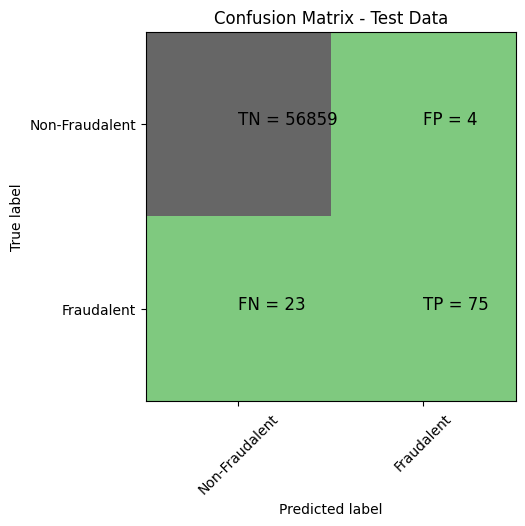

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56961
   macro avg       0.97      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc value: 0.9632269575962563
Random Forest threshold: 0.03
ROC for the test dataset: 96.3%
Time taken by model: ---509.0421504974365 seconds
------------------------------------------------------------
XGBoost Model
Model Accuracy: 0.999350432752234
Confusion Matrix


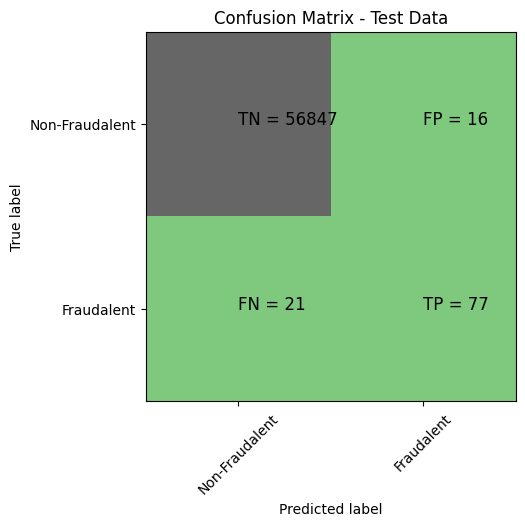

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.79      0.81        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGBoost roc value: 0.9696561230052754
XGBoost threshold: 0.00012316476204432547
ROC for the test dataset 97.0%
Time taken by model: ---10.21071743965149 seconds
------------------------------------------------------------


In [ ]:
# Run Logistic Regression with L1 and L2 regularisation
print('Logistic Regression with L1 and L2 regularisation')
start_time= time.time()
df_results = buildAndRunLogisticModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run KNN Model
print('KNN Model')
start_time= time.time()
df_results = buildAndRunKNNModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Decision Tree Models with gini and entropy criteria
print('Decision Tree Models with gini and entropy criteria')
start_time= time.time()
df_results = buildAndRunTreeModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run Random Forest Model
print('Random Forest Model')
start_time= time.time()
df_results = buildAndRunRandomForestModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

# Run XGBoost Model
print('XGBoost Model')
start_time= time.time()
df_results = buildAndRunXGBoostModels(df_results,"ADASYN Oversampling with StratifiedKFold", X_train_ADASYN, y_train_ADASYN ,X_test, y_test)
print("Time taken by model: ---%s seconds" % (time.time()-start_time))
print('-'*60)

**Results from ADASYN Oversampling:**

XGBoost provided the best results.

In [ ]:
df_results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold CV,Logistic Regression with L2 Regularisation,0.999105,0.987615,0.001934
1,RepeatedKFold CV,Logistic Regression with L1 Regularisation,0.999140,0.880455,0.095413
2,RepeatedKFold CV,KNN,0.999350,0.882510,0.200000
3,RepeatedKFold CV,DecisionTree Model with gini criteria,0.999192,0.892637,1.000000
4,RepeatedKFold CV,DecisionTree Model with entropy criteria,0.999245,0.897757,1.000000
5,RepeatedKFold CV,Random Forest,0.999631,0.942467,0.030000
6,RepeatedKFold CV,XGBoost,0.999614,0.976347,0.000178
7,StratifiedKFold CV,Logistic Regression with L2 Regularisation,0.998771,0.983387,0.001554
8,StratifiedKFold CV,Logistic Regression with L1 Regularisation,0.998754,0.889076,0.021087
9,StratifiedKFold CV,KNN,0.999192,0.805746,0.200000


###**Overall conclusion after running the models on Oversampled data:**

XGBoost model with Random Oversampling with StratifiedKFold CV has provided the best result under the category of all oversampling technique. Hence, we will tune the hyperparameters of this model to get best results.

##**Hyperparameter Tuning (HPT)**

###**HPT - XGBoost Regression**

In [ ]:
# Performing Hyperparameter tuning
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_test = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'n_estimators':range(60,130,150),
    'learning_rate':[0.05,0.1,0.125,0.15,0.2],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(7,10)],
    'colsample_bytree':[i/10.0 for i in range(7,10)]
}

#Would use GridSearchCV if there is enough computational power
gsearch1 = RandomizedSearchCV(
    estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                            colsample_bynode=1, max_delta_step=0, missing=None, n_jobs=1,
                            nthread=None, objective='binary:logistic', random_state=42,
                            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                            silent=None, verbosity=1),
    param_distributions = param_test, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([9.64379878, 6.9947783 , 6.48119597, 8.68567429, 6.44751015]),
  'std_fit_time': array([1.33308084, 1.21312908, 0.99663014, 1.1293143 , 1.02363057]),
  'mean_score_time': array([0.02965016, 0.02562051, 0.01971645, 0.02459188, 0.01932526]),
  'std_score_time': array([0.00703302, 0.00779818, 0.00277732, 0.00856636, 0.00695044]),
  'param_subsample': masked_array(data=[0.8, 0.7, 0.7, 0.9, 0.7],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[60, 60, 60, 60, 60],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 1, 5, 5],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_max_depth': masked_array(data=[7, 3, 3, 7, 3],
               mask=[False, False, False, False, False],
       

In [ ]:
# Create XGBoost model with the selected hyperparameters
from xgboost import XGBClassifier

clf = XGBClassifier(
    base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
    colsample_bytree=0.9, gamma=0.1, learning_rate=0.125, max_delta_step=0, max_depth=7,
    min_child_weight=1, n_estimators=60, n_jobs=1, nthread=None, objective='binary:logistic',
    random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.8, verbosity=1)

# Fit on the dataset
clf.fit(X_over, y_over)
XGB_test_score = clf.score(X_test, y_test)
print(f'Model Accuracy: {XGB_test_score}')

# Probabilities for each class
XGB_probs = clf.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print(f'XGBoost roc value: {XGB_roc_value}')
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print(f'XGBoost threshold: {threshold}')

Model Accuracy: 0.9993328768806727
XGBoost roc value: 0.9730427088092505
XGBoost threshold: 0.008000295609235764


###**Print the important features of the best model to understand the dataset**

In [ ]:
impt_var = []
for i in clf.feature_importances_:
  impt_var.append(i)

print('Top var=', impt_var.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var=', impt_var.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var=', impt_var.index(np.sort(clf.feature_importances_)[-3])+1)
print(f'XGBoost roc value: {XGB_roc_value}')
print(f'XGBoost threshold: {threshold}')

Top var= 14
2nd Top var= 10
3rd Top var= 4
XGBoost roc value: 0.9730427088092505
XGBoost threshold: 0.008000295609235764


##**Conclusion**

In the context of detecting credit card fraud transactions, the priority is often given to minimizing false negatives (fraudulent transactions predicted as non-fraud) since missing a fraudulent transaction can have significant financial consequences. Therefore, XGBoost model with Random Oversampling with StratifiedKFold CV would be the most suitible model since maximizing accuracy and being able to deal with imbalance classes are more critical.

XGBoost Model Accuracy: 0.9993328768806727

XGBoost roc value: 0.9730427088092505

XGBoost threshold: 0.008000295609235764

These are the top 3 freatures in prediciting if a transcation is fradulent:

*   Top var= 14
*   2nd Top var= 10
*   3rd Top var= 4
